In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import keras
from keras.layers import Dense, Dropout, Input
from keras.models import Model,Sequential
from keras.datasets import mnist
from tqdm import tqdm
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import adam
from keras.layers import Flatten
import matplotlib
import matplotlib.patches as mpatches
from scipy.stats import norm
from keras import layers
from keras.models import Model
from keras import metrics
from keras import backend as K   # 'generic' backend so code works with either tensorflow or theano
K.clear_session()
np.random.seed(237)

Using TensorFlow backend.


In [2]:
train_orig = pd.read_csv('train.csv')#(42000, 785) dataframe
test_orig = pd.read_csv('test.csv')#(28000, 784) datagrame
test_orig['label'] = 11
testCols = test_orig.columns.tolist()
testCols = testCols[-1:] + testCols[:-1]
test_orig = test_orig[testCols]
combined = pd.concat([train_orig, test_orig], ignore_index = True)# this line arange train orig and and test orig vertically and 
# having ascenfing order of id because igonre index is true
#combined has a shape of (70000, 785) and it is dataframe


valid = combined.sample(n = 5000, random_state = 555)# (5000, 785) dataframe
train = combined.loc[~combined.index.isin(valid.index)]#(65000, 785) dataframe

X_train = train.drop(['label'], axis = 1) #(65000, 784) datframe
X_valid = valid.drop(['label'], axis = 1) #(5000, 784) datafrmae
''' in above two lines we just dropped the columns of labels from train and valid and assign it to xtrain and xvalid 
this doesnt mean that train and valid dont have label now
'''
y_train = train['label']#series(65000,)
y_valid = valid['label']#series(5000,)


X_train = X_train.astype('float32') / 255.
X_train = X_train.values.reshape(-1,28,28,1)#(65000, 28, 28, 1)numpy.ndarray

X_valid = X_valid.astype('float32') / 255.
X_valid = X_valid.values.reshape(-1,28,28,1)#(5000, 28, 28, 1)numpy.ndarray
# in the abpve values function is used to covert dataframe into bumpy array


# the secod thing is we can also convert 5000, 28, 28, 1 itno 5000, 28, 28,
#65000, 28, 28, 1 into 65000, 28, 28

In [3]:
def create_generator():
    
    img_shape = (28, 28, 1)    # for MNIST
    batch_size = 20
    latent_dim = 2  # Number of latent dimension parameters

    # Encoder architecture: Input -> Conv2D*4 -> Flatten -> Dense
    input_img = keras.Input(shape=img_shape)

    x = layers.Conv2D(32, 3,
                  padding='same', 
                  activation='relu')(input_img)
    x = layers.Conv2D(64, 3,
                  padding='same', 
                  activation='relu',
                  strides=(2, 2))(x)
    x = layers.Conv2D(64, 3,
                  padding='same', 
                  activation='relu')(x)
    x = layers.Conv2D(64, 3,
                  padding='same', 
                  activation='relu')(x)
    # need to know the shape of the network here for the decoder
    shape_before_flattening = K.int_shape(x)

    x = layers.Flatten()(x)
    x = layers.Dense(32, activation='relu')(x)

    # Two outputs, latent mean and (log)variance
    z_mu = layers.Dense(latent_dim)(x)
    z_log_sigma = layers.Dense(latent_dim)(x)
    def sampling(args):
     z_mu, z_log_sigma = args
     
     epsilon = K.random_normal(shape=(K.shape(z_mu)[0], latent_dim),
                              mean=0., stddev=1.)
     return z_mu + K.exp(z_log_sigma) * epsilon

    # sample vector from the latent distribution
    z = layers.Lambda(sampling,output_shape=(latent_dim,) )([z_mu, z_log_sigma])#(None, 2) Tensor
    decoder_input = layers.Input(K.int_shape(z)[1:]) #(None, 2) Tensor
    x = layers.Dense(np.prod(shape_before_flattening[1:]),
                 activation='relu')(decoder_input) #(None, 12544)
    x = layers.Reshape(shape_before_flattening[1:])(x)  #(None, 14, 14, 64)

    x = layers.Conv2DTranspose(32, 3,
                           padding='same', 
                           activation='relu',
                           strides=(2, 2))(x) #(None, None, None, 32)

    x = layers.Conv2D(1, 3,
                  padding='same', 
                  activation='sigmoid')(x)#(None, None, None, 1)
    decoder = Model(decoder_input, x)
    z_decoded = decoder(z) #(None, None, None, 1)
    class CustomVariationalLayer(keras.layers.Layer):
          

      def vae_loss(self, x, z_decoded):
        x = K.flatten(x)
        z_decoded = K.flatten(z_decoded)
        # Reconstruction loss
        xent_loss = keras.metrics.binary_crossentropy(x, z_decoded)
        # KL divergence
        kl_loss = -5e-4 * K.mean(1 + z_log_sigma - K.square(z_mu) - K.exp(z_log_sigma), axis=-1)
        return K.mean(xent_loss + kl_loss)

     # adds the custom loss to the class
      def call(self, inputs):
        x = inputs[0]
        z_decoded = inputs[1]
        loss = self.vae_loss(x, z_decoded)
        self.add_loss(loss, inputs=inputs)
        return x

    # apply the custom loss to the input images and the decoded latent distribution sample
    y = CustomVariationalLayer()([input_img, z_decoded]) #(None, 28, 28, 1)
    #y=K.reshape(y,[784,1])
   
    vae = Model(input_img, y)
    vae.compile(optimizer='rmsprop', loss=None)
    print(vae.summary())
     

    
    return vae, decoder
g,ter=create_generator()
g.summary()

C:\Users\gaura\Anaconda3\lib\site-packages\keras\engine\training_utils.py:819: UserWarning: Output custom_variational_layer_1 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to custom_variational_layer_1.
  'be expecting any data to be passed to {0}.'.format(name))


Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 28, 28, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 14, 14, 64)   18496       conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 14, 14, 64)   36928       conv2d_2[0][0]                   
____________________________________________________________________________________________

In [4]:
def adam_optimizer():
    return adam(lr=0.0002,beta_1=0.5)

In [5]:

def create_discriminator():
    img_shape = (28,28,1)
    discriminator=Sequential()
    #(None, 28, 28, 1
    discriminator.add(Flatten(input_shape=[28,28,1]))
    #discriminator.add(Dense(units=1024,input_shape=()))
    discriminator.add(Dense(units=1024))
    
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))
       
    
    discriminator.add(Dense(units=512))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))
       
    discriminator.add(Dense(units=256))
    discriminator.add(LeakyReLU(0.2))
    
    discriminator.add(Dense(units=1, activation='sigmoid'))
    
    discriminator.compile(loss='binary_crossentropy', optimizer=adam_optimizer())
    return discriminator
d =create_discriminator()
d.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 1024)              803840    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 1024)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 512)               524800    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)              

In [6]:
def create_gan(discriminator, vae):
    discriminator.trainable=False
    gan_input = Input(shape=(28, 28, 1))
    x = vae (gan_input)
    gan_output= discriminator (x)
    gan= Model(inputs=gan_input, outputs=gan_output)
    gan.compile(loss='binary_crossentropy', optimizer='adam')
    return gan
gan = create_gan(d,g)
gan.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
model_2 (Model)              (None, 28, 28, 1)         550629    
_________________________________________________________________
sequential_1 (Sequential)    (None, 1)                 1460225   
Total params: 2,010,854
Trainable params: 550,629
Non-trainable params: 1,460,225
_________________________________________________________________


In [7]:
'''def plot_generated_images(epoch, vae, examples=100, dim=(10,10), figsize=(10,10)):
    noise= np.random.normal(loc=0, scale=1, size=[examples, 100])
    generated_images = vae.predict(noise)
    generated_images = generated_images.reshape(100,28,28)
    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generated_images[i], interpolation='nearest')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('gan_generated_image %d.png' %epoch)
    '''

"def plot_generated_images(epoch, vae, examples=100, dim=(10,10), figsize=(10,10)):\n    noise= np.random.normal(loc=0, scale=1, size=[examples, 100])\n    generated_images = vae.predict(noise)\n    generated_images = generated_images.reshape(100,28,28)\n    plt.figure(figsize=figsize)\n    for i in range(generated_images.shape[0]):\n        plt.subplot(dim[0], dim[1], i+1)\n        plt.imshow(generated_images[i], interpolation='nearest')\n        plt.axis('off')\n    plt.tight_layout()\n    plt.savefig('gan_generated_image %d.png' %epoch)\n    "

In [8]:
def training(epochs=400, batch_size=20):
    
    #Loading the data
    #X_train = X_train.values.reshape(-1,28,28,1)#(65000, 28, 28, 1)numpy.ndarray
    batch_count = X_train.shape[0] / batch_size
    
    # Creating GAN
    vae,ter= create_generator()
    discriminator= create_discriminator()
    gan = create_gan(discriminator, vae)
    
    for e in range(1,epochs+1 ):
        print("Epoch %d" %e)
        for _ in tqdm(range(int(batch_count))):
        #generate  random noise as an input  to  initialize the  generator
            noise= np.random.normal(0,1, [batch_size, 100])
            n = 20  # figure with 20x20 digits
            digit_size = 28
            figure = np.zeros((digit_size * n, digit_size * n))

            # Construct grid of latent variable values
            grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
            grid_y = norm.ppf(np.linspace(0.05, 0.95, n))
            numr=0

            # decode for each square in the grid
            for i, yi in enumerate(grid_x):
             for j, xi in enumerate(grid_y):
              z_sample = np.array([[xi, yi]])
              z_sample = np.tile(z_sample, batch_size).reshape(batch_size, 2)
              x_decoded = ter.predict(z_sample, batch_size=batch_size) #20,28,28,1
              
            
              digit = x_decoded[0].reshape(digit_size, digit_size)
              figure[i * digit_size: (i + 1) * digit_size,j * digit_size: (j + 1) * digit_size] = digit
                

            plt.figure(figsize=(10, 10))
            plt.imshow(figure, cmap='gnuplot2')
            plt.savefig("figure{y}.png".format(y=numr))
            numr=numr+1
            plt.show()  
            
            # Generate fake MNIST images from noised input
            generated_images = ter.predict(z_sample, batch_size=batch_size)#(20, 28, 28, 1)
            
            #generated_images = generated_images.reshape(20,28,28)
            #generated_images = generated_images.reshape(20,784)
            # Get a random set of  real images
            image_batch =X_train[np.random.randint(low=0,high=X_train.shape[0],size=batch_size)]
            #image_batch=image_batch.reshape(20,28,28)
            #image_batch=image_batch.reshape(20,784)
            
            
            #Construct different batches of  real and fake data 
            X= np.concatenate([image_batch, generated_images])
            print(X.shape)
            #X shape-(40,784)
            # Labels for generated and real data
            y_dis=np.zeros(2*batch_size)
            y_dis[:batch_size]=0.9
            
            #Pre train discriminator on  fake and real data  before starting the gan. 
            discriminator.trainable=True
            discriminator.train_on_batch(X, y_dis)
           
            #--
            #Tricking the noised input of the Generator as real data
            #noise= np.random.normal(0,1, [batch_size, 100])
            y_gen = np.ones(batch_size)
            
            # During the training of gan, 
            # the weights of discriminator should be fixed. 
            #We can enforce that by setting the trainable flag
            discriminator.trainable=False
            
            #training  the GAN by alternating the training of the Discriminator 
            #and training the chained GAN model with Discriminator’s weights freezed.
            gan.train_on_batch(generated_images, y_gen)
            
        
           
            #plot_generated_images(e, vae)


C:\Users\gaura\Anaconda3\lib\site-packages\keras\engine\training_utils.py:819: UserWarning: Output custom_variational_layer_2 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to custom_variational_layer_2.
  'be expecting any data to be passed to {0}.'.format(name))


Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 28, 28, 32)   320         input_4[0][0]                    
__________________________________________________________________________________________________
conv2d_7 (Conv2D)               (None, 14, 14, 64)   18496       conv2d_6[0][0]                   
__________________________________________________________________________________________________
conv2d_8 (Conv2D)               (None, 14, 14, 64)   36928       conv2d_7[0][0]                   
____________________________________________________________________________________________

  0%|          | 0/3250 [00:00<?, ?it/s]

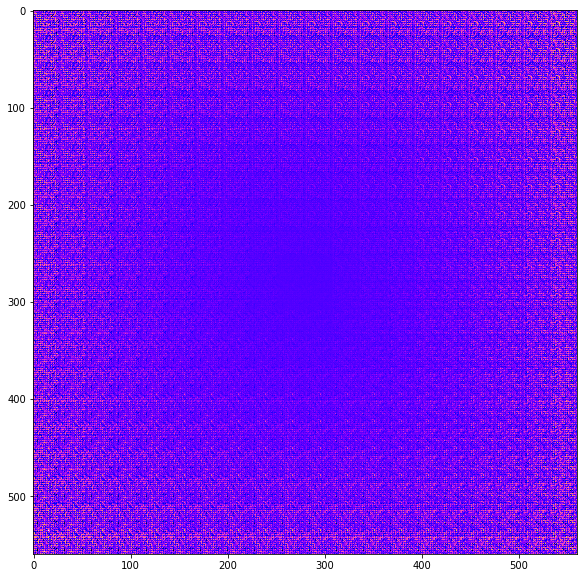

(40, 28, 28, 1)


InvalidArgumentError:  You must feed a value for placeholder tensor 'input_4' with dtype float and shape [?,28,28,1]
	 [[node input_4 (defined at C:\Users\gaura\Anaconda3\lib\site-packages\tensorflow_core\python\framework\ops.py:1751) ]] [Op:__inference_keras_scratch_graph_6752]

Function call stack:
keras_scratch_graph


In [9]:
training(400,20)

In [ ]:
g.summar

In [ ]:
 np.ones(16).shape

In [ ]:
__inference_keras_scratch_graph_6752